The BSD68 dataset was adapted from K. Zhang et al (TIP, 2017) and is composed of natural
images. The noise was artificially added, allowing for quantitative comparisons with the
ground truth, one of the benchmark used in many denoising publications. Here, we check 
the performances of Noise2Void using the Lightning API of CAREamics.

This API gives you more freedom to customize the training by using wrappers around the
main elements of CAREamics: the datasets and the lightning module.

In [1]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tifffile
from careamics.lightning import (
    CAREamicsModuleWrapper,
    PredictDataWrapper,
    TrainingDataWrapper,
)
from careamics.prediction_utils import convert_outputs
from careamics.utils.metrics import psnr
from careamics_portfolio import PortfolioManager
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

In [2]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
files = portfolio.denoising.N2V_BSD68.download(root_path)

# create paths for the data
data_path = Path(root_path / "denoising-N2V_BSD68.unzip/BSD68_reproducibility_data")
train_path = data_path / "train"
val_path = data_path / "val"
test_path = data_path / "test" / "images"
gt_path = data_path / "test" / "gt"

## Visualize data

Text(0.5, 1.0, 'Validation Image')

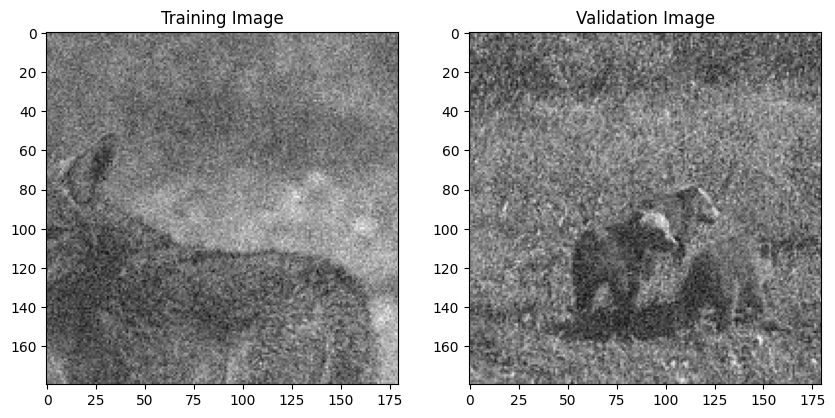

In [3]:
# load training and validation image and show them side by side
single_train_image = tifffile.imread(next(iter(train_path.rglob("*.tiff"))))[0]
single_val_image = tifffile.imread(next(iter(val_path.rglob("*.tiff"))))[0]

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(single_train_image, cmap="gray")
ax[0].set_title("Training Image")
ax[1].imshow(single_val_image, cmap="gray")
ax[1].set_title("Validation Image")

## Train with the CAREamics Lightning API

Using the Lightning API of CAREamics, you need to instantiate the lightning module, the 
data module and the trainer yourself.

### Create the Lightning module

In [4]:
model = CAREamicsModuleWrapper(
    algorithm="n2v",
    loss="n2v",
    architecture="UNet",
    model_parameters={"n2v2": False},
)

### Create the data module

In [5]:
train_data_module = TrainingDataWrapper(
    train_data=train_path,
    val_data=val_path,
    data_type="tiff",
    patch_size=(64, 64),
    axes="SYX",
    batch_size=64,
)

### Create the trainer

Note that here we modify the prediction loop, but this will be  changed in the near
future.

In [6]:
# Create Callbacks
root = Path("bsd68_n2v")
callbacks = [
    ModelCheckpoint(
        dirpath=root / "checkpoints",
        filename="bsd68_lightning_api",
        save_last=True,
    )
]

# Create a Lightning Trainer
trainer = Trainer(max_epochs=1, default_root_dir=root, callbacks=callbacks)

# Train the model
trainer.fit(model, datamodule=train_data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Extracted 28512 patches from input array.
Computed dataset mean: [110.75294], std: [63.60386]
Extracted 36 patches from input array.
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


## Predict with CAREamics Lightning API

### Define the prediction datamodule

In [8]:
# means, stds = train_data_module.get_data_statistics()
# pred_data_module = PredictDataWrapper(
#     pred_data=test_path,
#     data_type="tiff",
#     axes="YX",
#     batch_size=1,
#     tta_transforms=True,
#     image_means=means,
#     image_stds=stds,
#     tile_size=(128, 128),
#     tile_overlap=(32, 32),
# )

### Predict

In [10]:
########################################################
# Note: currently, directly predicting on a folder
#       does not work in this notebook. This will be
#       fixed in the near future.
# see: https://github.com/CAREamics/careamics/issues/162
########################################################
means, stds = train_data_module.get_data_statistics()
files = list(test_path.rglob("*.tiff"))
files.sort()
predictions = []

for file in files:
    pred_data_module = PredictDataWrapper(
        pred_data=file,
        data_type="tiff",
        axes="YX",
        batch_size=1,
        tta_transforms=True,
        image_means=means,
        image_stds=stds,
        tile_size=(128, 128),
        tile_overlap=(32, 32),
    )

    # Predict
    prediction = trainer.predict(model, datamodule=pred_data_module)

    # Convert the outputs to the original format, mostly useful if tiling is used
    prediction = convert_outputs(prediction, tiled=True)
    predictions.append(prediction)

/Users/joran.deschamps/miniconda3/envs/careamics/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# # Predict
# prediction = trainer.predict(model, datamodule=pred_data_module)

# # Convert the outputs to the original format, mostly useful if tiling is used
# prediction = convert_outputs(prediction, tiled=True)

### Visualize the prediction

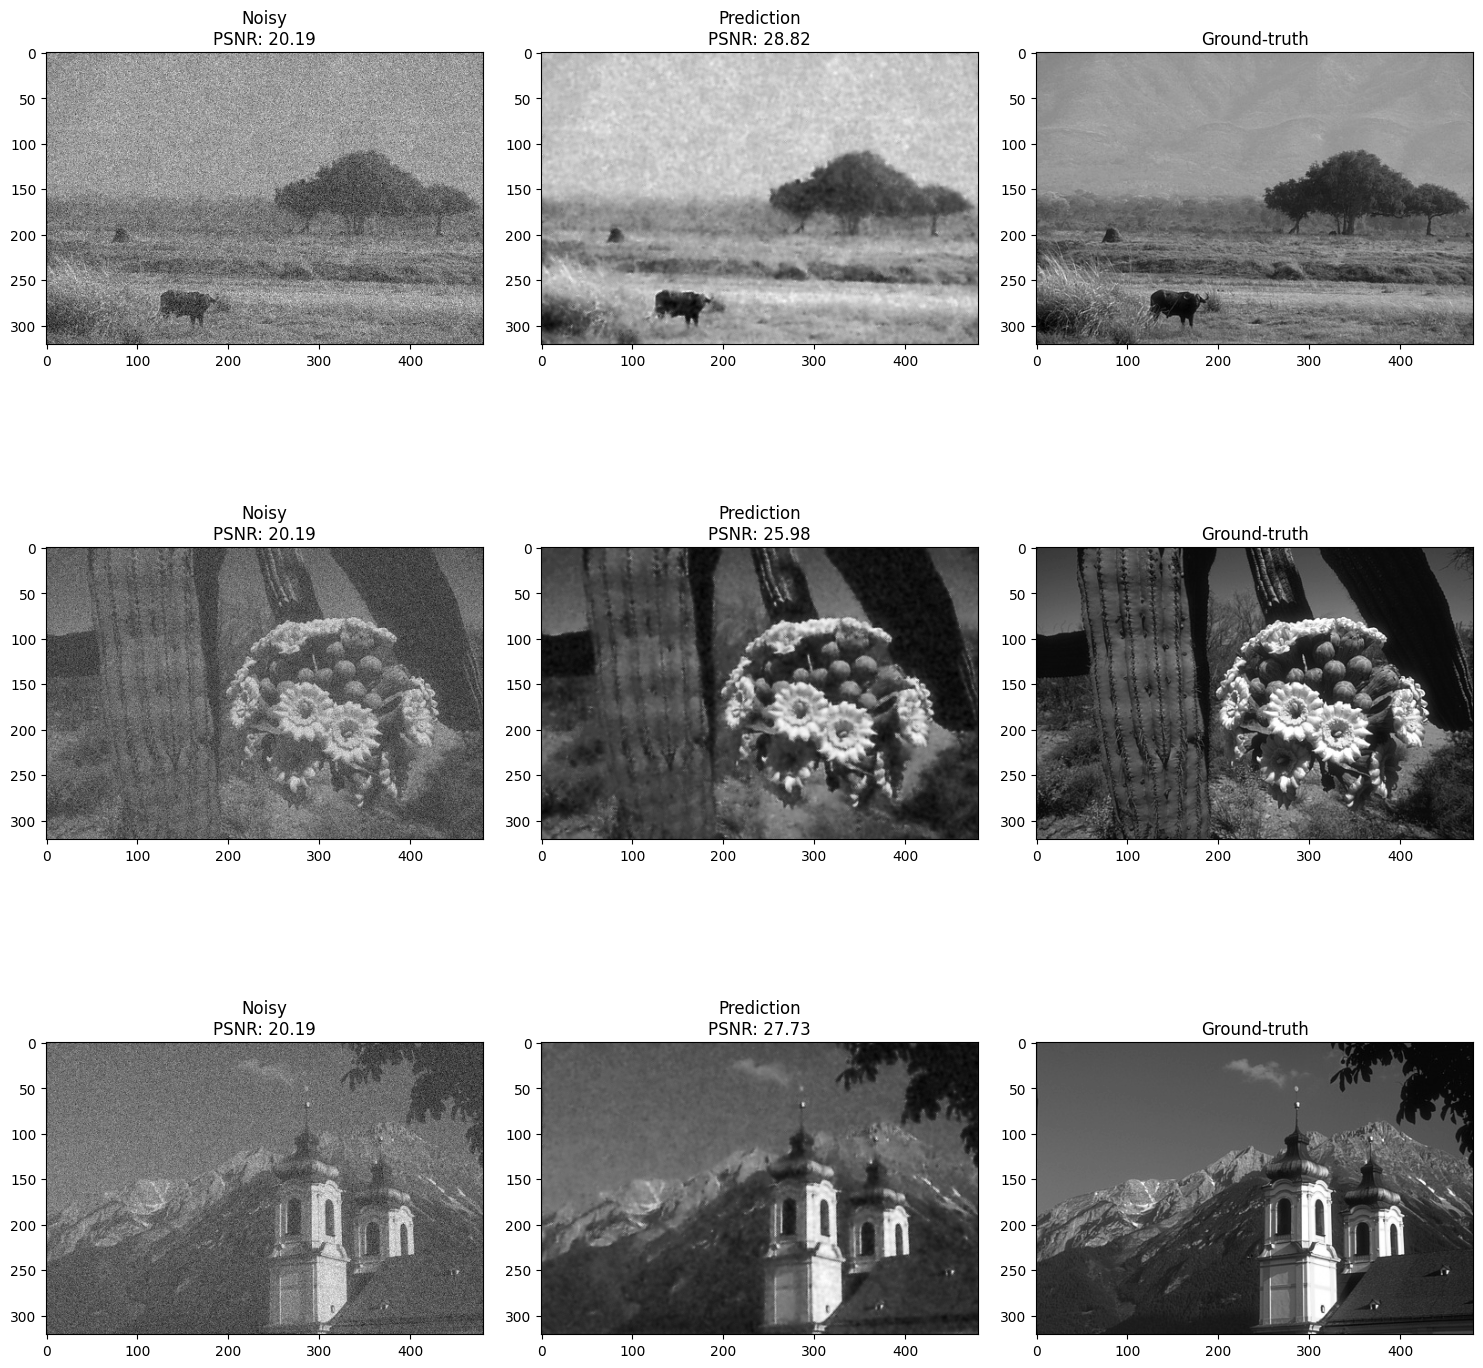

In [11]:
# Show two images
noises = [tifffile.imread(f) for f in sorted(test_path.glob("*.tiff"))]
gts = [tifffile.imread(f) for f in sorted(gt_path.glob("*.tiff"))]

# images to show
images = np.random.choice(range(len(noises)), 3)

fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout()

for i in range(3):
    pred_image = predictions[images[i]]
    psnr_noisy = psnr(gts[images[i]], noises[images[i]])
    psnr_result = psnr(gts[images[i]], pred_image)

    ax[i, 0].imshow(noises[images[i]], cmap="gray")
    ax[i, 0].title.set_text(f"Noisy\nPSNR: {psnr_noisy:.2f}")

    ax[i, 1].imshow(pred_image, cmap="gray")
    ax[i, 1].title.set_text(f"Prediction\nPSNR: {psnr_result:.2f}")

    ax[i, 2].imshow(gts[images[i]], cmap="gray")
    ax[i, 2].title.set_text("Ground-truth")

### Compute metrics

In [19]:
psnrs = np.zeros((len(prediction), 1))

for i, (pred, gt) in enumerate(zip(predictions, gts)):
    psnrs[i] = psnr(gt, pred)

print(f"PSNR: {psnrs.mean():.2f} +/- {psnrs.std():.2f}")
print("Reported PSNR: 27.71")

PSNR: 5.55 +/- 10.76
Reported PSNR: 27.71
